In [1]:
import sqlite3
import pandas
import seaborn as sns
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
conn = sqlite3.connect('words.db')
cur = conn.cursor()

## Для всех слов

In [3]:
cur.execute('''
            select word 
            from main 
            where type != 'несловарно'
            order by freq DESC
            ''')
lines = cur.fetchall()

In [4]:
def find_avg_len(lines):
    for i in range(len(lines)):
        lines[i] = lines[i][0]
    k = ''.join(lines)
    l0 = len(lines)
    l1 = len(k)
    print('Средняя длина токена: ', l1/l0)

In [5]:
find_avg_len(lines)

Средняя длина токена:  9.518513946349927


## Для неоднозначных по части речи и лемме

In [6]:
cur.execute('''
            select word 
            from main 
            where type = 'неоднозначно по части речи и лемме'
            order by freq DESC
            ''')
lines = cur.fetchall()

In [7]:
find_avg_len(lines)

Средняя длина токена:  8.43981088616802


## Для остальных

In [8]:
cur.execute('''
            select word 
            from main 
            where type != 'неоднозначно по части речи и лемме' and type != 'несловарно'
            order by freq DESC
            ''')
lines = cur.fetchall()

In [9]:
find_avg_len(lines)

Средняя длина токена:  9.651958578905536


# С разделением по границе (6 знаков)

In [10]:
cur.execute('''
            select pos_tag_lemma.word, type -- что тут происходит?
            from pos_tag_lemma
            join main on pos_tag_lemma.word = main.word
            where type != 'несловарно'
            group by pos_tag_lemma.word
            order by freq DESC
            ''')
lines = cur.fetchall()

In [11]:
short = {}
long = {}
for line in lines:
    if len(line[0]) >= 6:
        long[line[0]] = line[1]
    else:
        short[line[0]] = line[1]

In [12]:
short_c = Counter(short.values())
short_p = {}
for key in short_c.keys():
    short_p[key] = short_c[key]/len(short)

In [13]:
long_c = Counter(long.values())
long_p = {}
for key in long_c.keys():
    long_p[key] = long_c[key]/len(long)

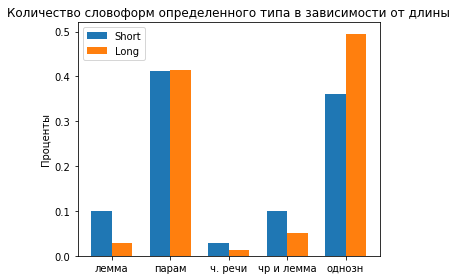

In [14]:
labels = ['лемма', 'парам', 'ч. речи', 'чр и лемма', 'однозн']
short_means = [short_p[key] for key in sorted(long_p.keys())]
long_means = [long_p[key] for key in sorted(long_p.keys())]

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, short_means, width, label='Short')
rects2 = ax.bar(x + width/2, long_means, width, label='Long')

ax.set_ylabel('Проценты')
ax.set_title('Количество словоформ определенного типа в зависимости от длины')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Более интеллектуальный подход

In [15]:
cur.execute('''
            select word, type
            from main
            where type != 'несловарно'
            order by freq DESC
            limit 30000
            ''')
lines = cur.fetchall()

In [16]:
lengths = {'<=2':[], '3':[], '4':[], '5':[], '6':[], '7':[], 
           '8':[], '9':[], '10':[], '11':[], '12':[], '>=13':[]}
for line in lines:
    if len(line[0]) <= 2:
        lengths['<=2'].append(line[1])
    elif len(line[0]) == 3:
        lengths['3'].append(line[1])
    elif len(line[0]) == 4:
        lengths['4'].append(line[1])
    elif len(line[0]) == 5:
        lengths['5'].append(line[1])
    elif len(line[0]) == 6:
        lengths['6'].append(line[1])
    elif len(line[0]) == 7:
        lengths['7'].append(line[1])
    elif len(line[0]) == 8:
        lengths['8'].append(line[1])
    elif len(line[0]) == 9:
        lengths['9'].append(line[1])
    elif len(line[0]) == 10:
        lengths['10'].append(line[1])
    elif len(line[0]) == 11:
        lengths['11'].append(line[1])
    elif len(line[0]) == 12:
        lengths['12'].append(line[1])
    else:
        lengths['>=13'].append(line[1])

In [17]:
for l in lengths.keys():
    all_ = len(lengths[l])
    cnt = Counter(lengths[l])
    for c in cnt:
        cnt[c] = cnt[c]/all_
    lengths[l] = cnt

In [18]:
df = pandas.DataFrame.from_dict(lengths).transpose()

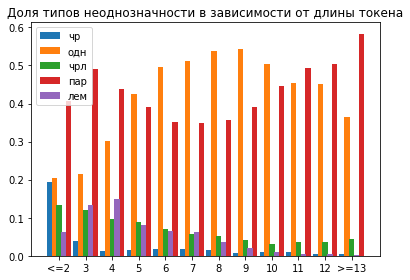

In [19]:
labels = ['<=2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '>=13']
          
amb_pos = list(df['неоднозначно по части речи'])
disamb = list(df['однозначно'])
amb_p_lem = list(df['неоднозначно по части речи и лемме'])
amb_par = list(df['неоднозначно по параметрам'])
amb_lem = list(df['неоднозначно по лемме'])

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - 9*width/5, amb_pos, width, label='чр')
rects2 = ax.bar(x - 4.5*width/5, disamb, width, label='одн')
rects3 = ax.bar(x, amb_p_lem, width, label='чрл')
rects4 = ax.bar(x + 9*width/5, amb_par, width, label='пар')
rects5 = ax.bar(x + 4.5*width/5, amb_lem, width, label='лем')

ax.set_title('Доля типов неоднозначности в зависимости от длины токена')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

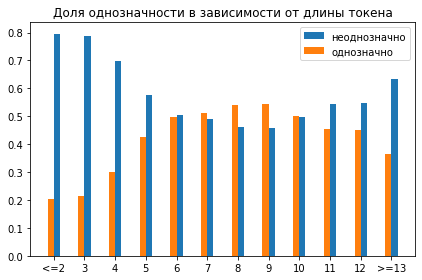

In [20]:
labels = ['<=2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '>=13']
          
disamb = list(df['однозначно'])
amb = [1-i for i in disamb]

x = np.arange(len(labels)) 
width = 0.2 

fig, ax = plt.subplots()
rects1 = ax.bar(x + width/2, amb, width, label='неоднозначно')
rects2 = ax.bar(x - width/2, disamb, width, label='однозначно')


ax.set_title('Доля однозначности в зависимости от длины токена')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()